# Import Modules

In [1]:
import numpy as np
import os
import PIL 
import PIL.Image
import tensorflow as tf
import pathlib

# Load Dataset

In [2]:
dataset_path = "./dataset/"
data_dir = pathlib.Path(dataset_path).with_suffix("")

# Read Dataset

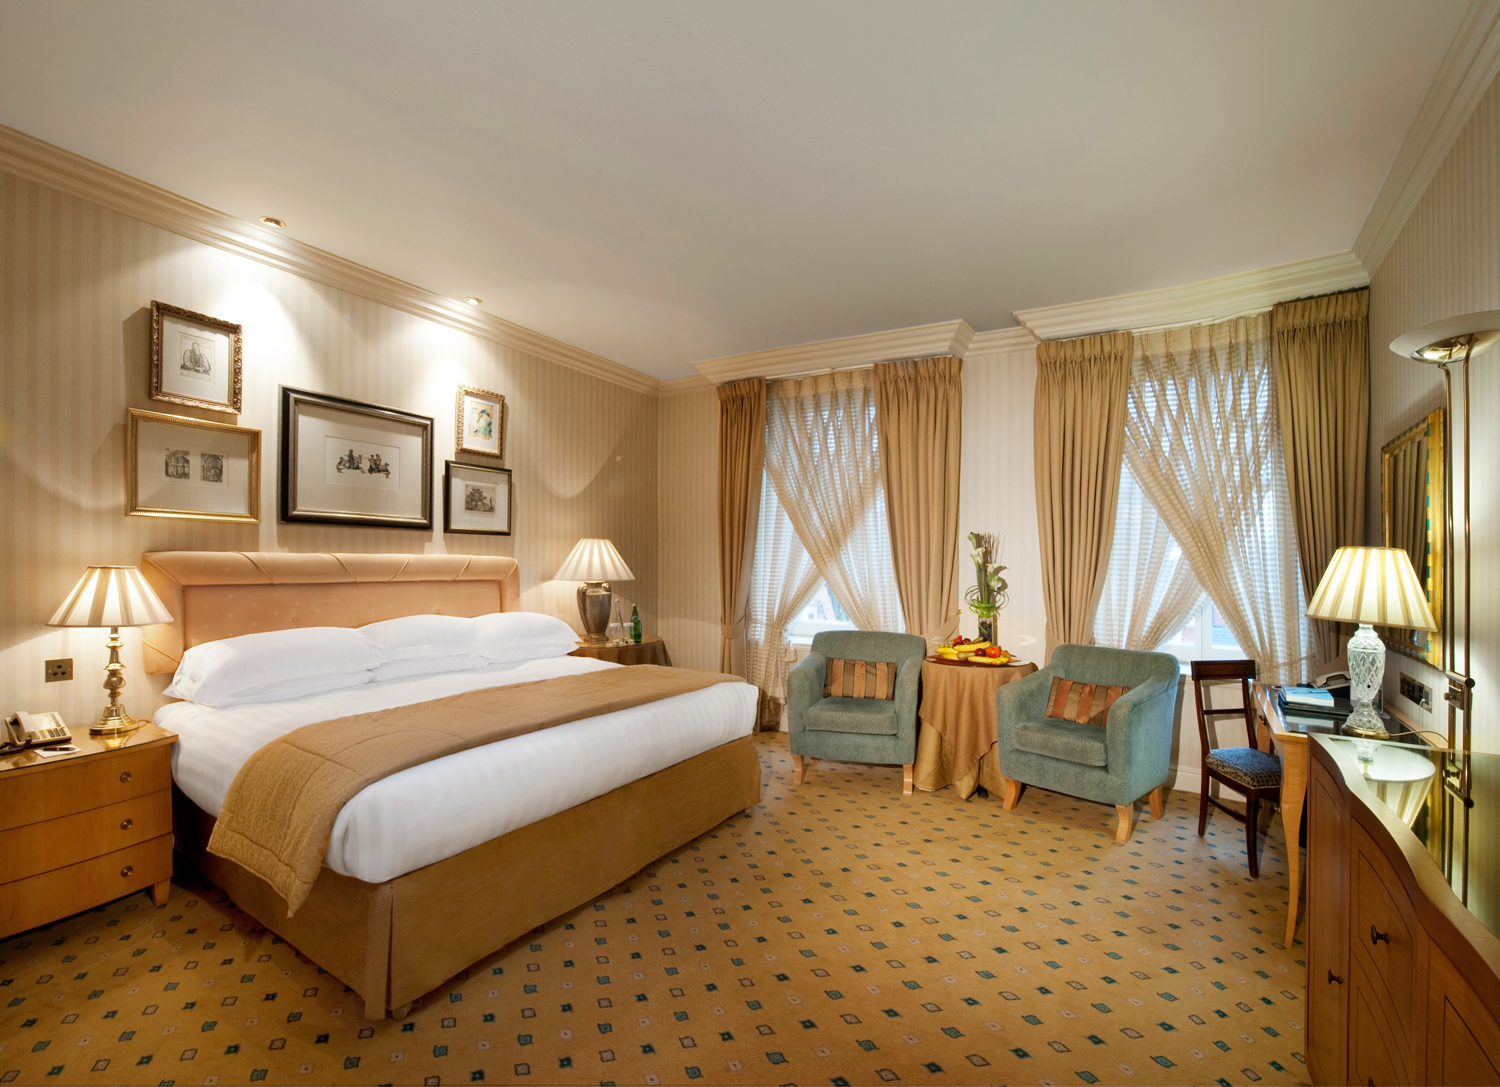

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))

non_fire_images = list(data_dir.glob('0/*'))
PIL.Image.open(str(non_fire_images[0]))

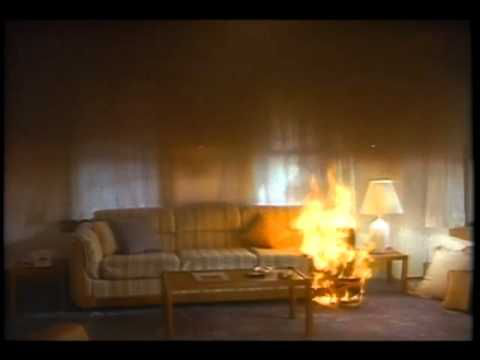

In [4]:
fire_images = list(data_dir.glob('1/*'))
PIL.Image.open(str(fire_images[1]))

# Creating a Dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Creating training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 651 files belonging to 2 classes.
Using 521 files for training.


In [7]:
# Creating validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 651 files belonging to 2 classes.
Using 130 files for validation.


In [8]:
class_names = ["Not a fire", "Fire"]
print(class_names)

['Not a fire', 'Fire']


# Visualize The Data

In [9]:
import matplotlib.pyplot as plt

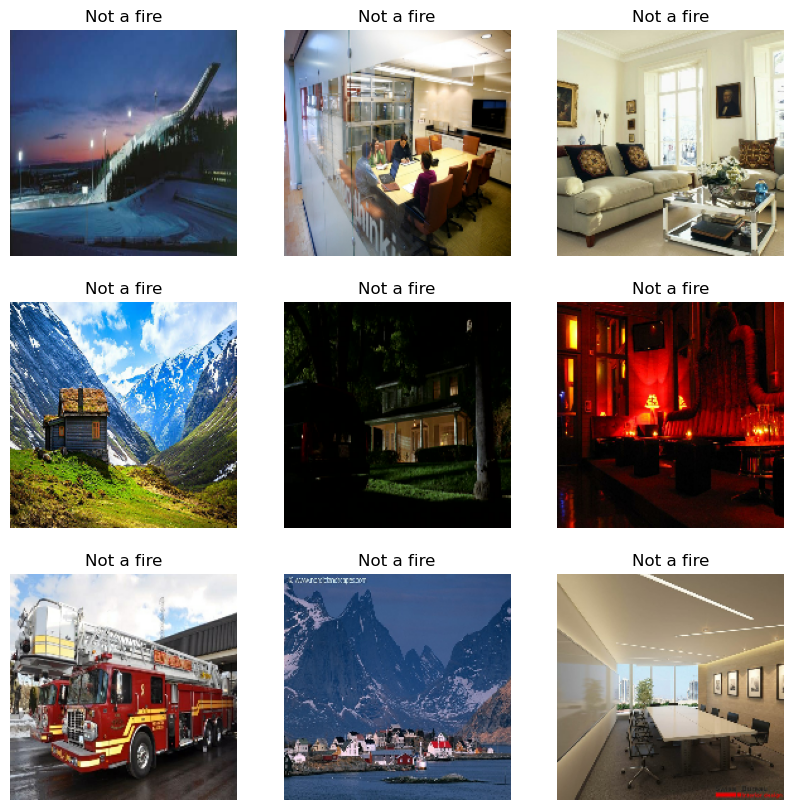

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


# Normalize The Data

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.029771158 1.0


# Configure Dataset Performance

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Train The Model

In [34]:
num_classes = 1

# Create a model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes)
])

# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# Fit the model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
17/17 [==============================] - 5s 288ms/step - loss: 0.4220 - accuracy: 0.8330 - val_loss: 0.3240 - val_accuracy: 0.8231
Epoch 2/10
17/17 [==============================] - 5s 281ms/step - loss: 0.3266 - accuracy: 0.8388 - val_loss: 0.3386 - val_accuracy: 0.8231
Epoch 3/10
17/17 [==============================] - 5s 277ms/step - loss: 0.2843 - accuracy: 0.8484 - val_loss: 0.2880 - val_accuracy: 0.8846
Epoch 4/10
17/17 [==============================] - 5s 280ms/step - loss: 0.2388 - accuracy: 0.8964 - val_loss: 0.3238 - val_accuracy: 0.8846
Epoch 5/10
17/17 [==============================] - 5s 281ms/step - loss: 0.2104 - accuracy: 0.9155 - val_loss: 0.3256 - val_accuracy: 0.8769
Epoch 6/10
17/17 [==============================] - 6s 334ms/step - loss: 0.1620 - accuracy: 0.9309 - val_loss: 0.2418 - val_accuracy: 0.9077
Epoch 7/10
17/17 [==============================] - 6s 339ms/step - loss: 0.1097 - accuracy: 0.9539 - val_loss: 0.2460 - val_accuracy: 0.9077
Epoch 

# Testing The Model

In [27]:
def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.cast(img, tf.float32) / 255.0
    return img

In [35]:
test_image = decode_image(tf.io.read_file("./HomeFiresReport.jpg"))
model.predict([tf.expand_dims(test_image, axis=0)])

1/1 [==============================] - 0s 61ms/step


array([[-1.7952244]], dtype=float32)